# The parallel and fixation mutations of SARS-CoV-2

Use `sitePath` on all proteins of SARS-CoV-2 to monitor the occurrence of parallel and fixation mutations. The trees from May 2020 to May 2021 were acquired from [NextStrain](https://nextstrain.org/ncov/gisaid/global) and the sequences were downloaded from [GISAID](https://www.epicov.org/epi3/frontend).

In [1]:
import os
import json
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

DATA_DIR = os.path.join("Data", "SARS-CoV-2_genome")
OUTPUT_DIR = "Output"

In [2]:
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold'})
fontsize = 20

In [3]:
siteLabel = pd.read_csv(os.path.join(DATA_DIR, "siteLabel.csv"))

In [4]:
paraFixSites = pd.read_csv(os.path.join(DATA_DIR, "paraFixSites.csv"))
paraFixSites["date"] = pd.to_datetime(paraFixSites["date"])
paraFixSites.loc[paraFixSites["type"] == "paraFix", "type"] = "parallel"

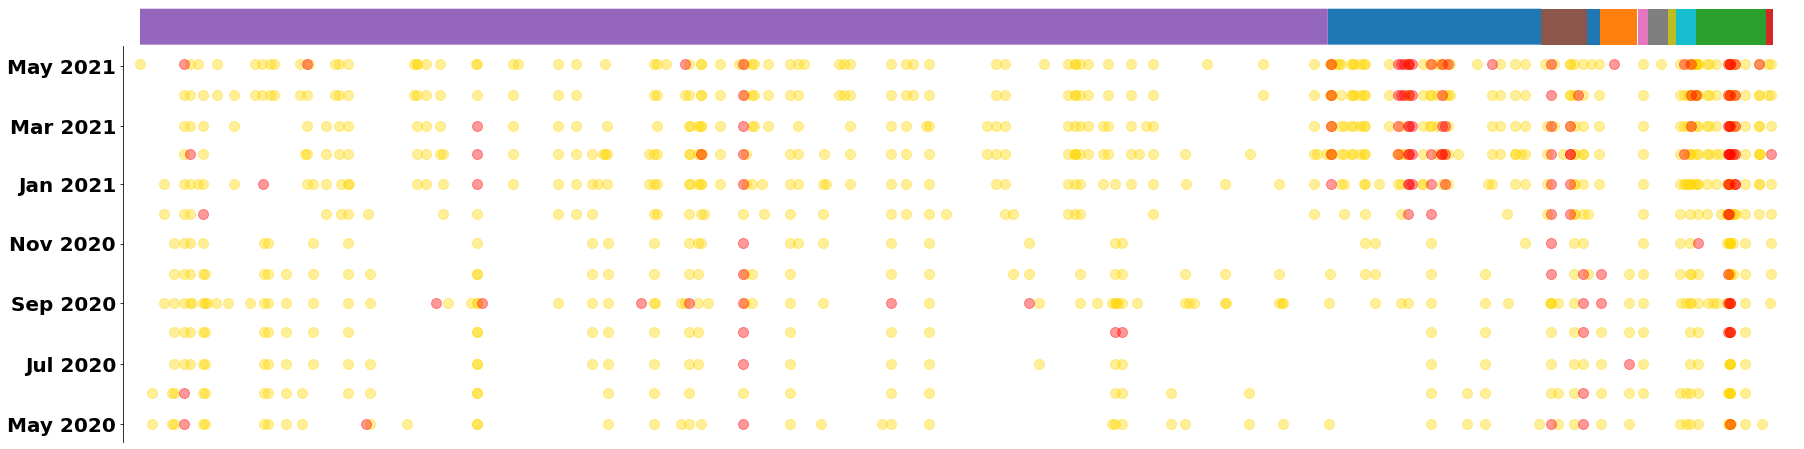

In [5]:
typeColors = {
    "fixation": "gold",
    "parallel": "red"
}

y_pos = paraFixSites["date"].unique()
y_pos.sort()

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(30, 8),
    gridspec_kw={ "height_ratios": [1, 10], "hspace": 0 }
)

ax = axes[0]
for name, group in siteLabel.groupby("name"):
    ax.fill_between(group["peptidePos"], 0, 1)
ax.axis("off")

ax = axes[1]
for mutType, group in paraFixSites.groupby("type"):
    ax.scatter(group["site"], group["date"], s=100, alpha=0.4, c=typeColors[mutType])
ax.set_xlim([-100, 9900])
# ax.set_xticks(paraFixSites["site"])
ax.set_xticks([])
ax.set_xticklabels([])
ax.yaxis.set_major_formatter(DateFormatter('%b %Y'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig(os.path.join(OUTPUT_DIR, "paraFixedMonthly.pdf"), bbox_inches="tight")
plt.show()

In [6]:
mutSites = pd.read_csv(os.path.join(DATA_DIR, "mutSites.csv"), index_col=0)
mutSites = mutSites[mutSites['Var1'].str.len() == 10]
mutSites['Var1'] = pd.to_datetime(mutSites['Var1'])
mutSites = mutSites[mutSites['Var1'] > datetime.datetime(2019, 11, 30)]
mutSites.set_index("Var1", inplace=True)

In [7]:
background = pd.read_csv(os.path.join(DATA_DIR, "background.csv"), index_col=0)
background = background[background['Var1'].str.len() == 10]
background['Var1'] = pd.to_datetime(background['Var1'])
background = background[background['Var1'] > datetime.datetime(2019, 11, 30)]
background.set_index("Var1", inplace=True)

In [8]:
with open(os.path.join(DATA_DIR, "parallelFirstDate.json")) as f:
    parallelFirstDate = json.load(f)

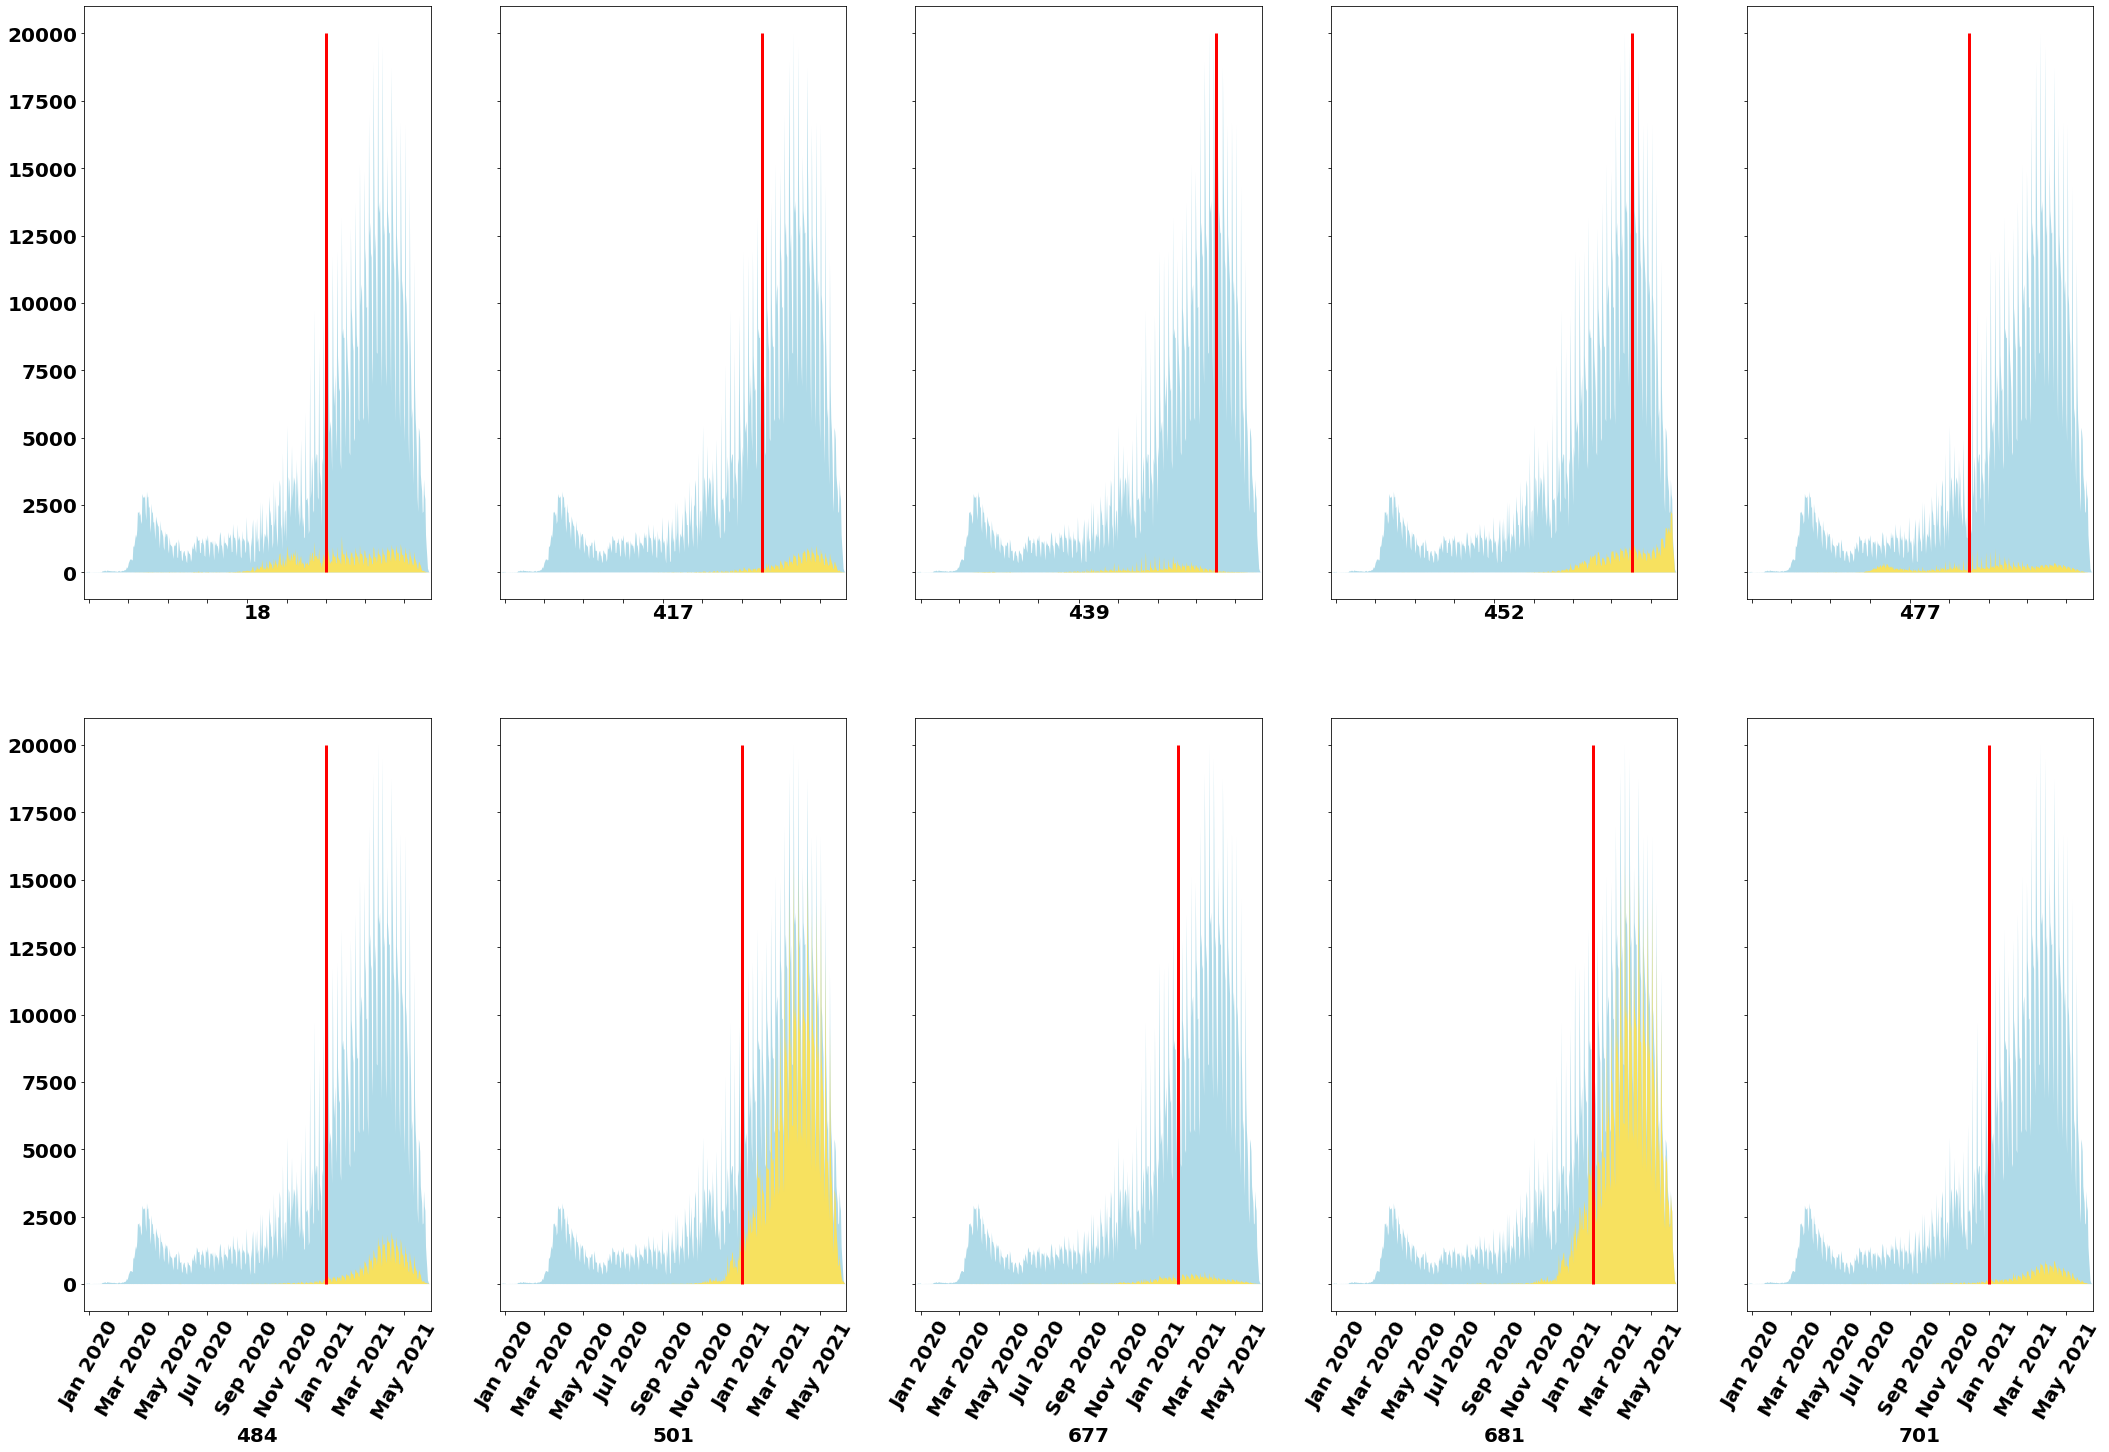

In [9]:
x_pos = background.index.unique()
x_pos.sort_values()
x_pos = pd.to_datetime(x_pos)

nrows = 2
ncols = 5

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharex=True,
    sharey=True,
    figsize = (3 * ncols * 2.4, 24)
)
axes2 = []
for ax in axes:
    axes2.extend(ax)

n = 0
for site, meta in mutSites.groupby("site"):
    mutNum = []
    bgNum = background['Freq'].values

    for d in x_pos:
        if d in meta.index:
            mutNum.append(meta.loc[d, "Freq"])
        else:
            mutNum.append(0)
    if str(site) in parallelFirstDate and site != 614:
        ax = axes2[n]
        n += 1
        ax.fill_between(x_pos, 0, bgNum, label = "Backgroup", facecolor='#AFDAE8')
        ax.fill_between(x_pos, 0, mutNum, label = "mutation", facecolor='#F7E15F')
        ax.vlines(x=parallelFirstDate[str(site)], colors="red", ymin=0, ymax=max(bgNum), linewidth=3)
        ax.tick_params(axis='x', labelrotation=60)
        ax.set_xlim([x_pos[1], x_pos[-1]])
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.set_xlabel(site, fontsize=fontsize, fontweight='bold')

plt.savefig(os.path.join(OUTPUT_DIR, "parallelSites.pdf"), bbox_inches="tight")
plt.show()